In [1]:
import scipy.io
from scipy.sparse import random
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import xlsxwriter

import esn_functions

# load data from matlab file mackeyglass time series
loaded_mat = scipy.io.loadmat('MGTimeseries_dde23_tau17.mat')
data_tau17 = loaded_mat['MGseries_dde23_tau17'][0]
data_tau50 = loaded_mat['MGseries_dde23_tau50'][0]

# clean dataset
data = pd.DataFrame({'tau17': data_tau17}) # use tau=17 first
data.index = data.index + 1

# split data set
training_data = data.loc[1:3001]
testing_data = data.loc[3002:]

In [22]:
training_data

,tau17
1,0.200000
2,0.117559
3,0.042963
4,-0.024534
5,-0.085607
...,...
2997,-0.202397
2998,-0.250349
2999,-0.295667
3000,-0.338844


In [2]:
def gen_matrix(shape, sparsity, sd=1, mean=0, loc_seed=100, val_seed=100, pdf="gaussian", seeded=True):
    
    def seeded_rvs_gauss(array_len):
            return stats.norm(loc=mean, scale=sd).rvs(random_state = val_seed, size=array_len)

    def seeded_rvs_uniform(array_len):
        return stats.uniform(loc=mean, scale=sd).rvs(random_state = val_seed, size=array_len)

    m = shape[0]
    n = shape[1]

    if seeded == True:
        
        if pdf == "gaussian":
            M = random(m, n, density=sparsity, random_state=loc_seed, data_rvs=seeded_rvs_gauss).A
            return M

        if pdf == "uniform":
            M = random(m, n, density=sparsity, random_state=loc_seed, data_rvs=seeded_rvs_uniform).A
            return M

        if pdf == "ones":
            M = random(m, n, density = sparsity, random_state=loc_seed, data_rvs=np.ones).A
            return M
        else: 
            print("No such pdf")
            
    elif seeded == False:
        
        if pdf == "gaussian":
            unseeded_rvs = stats.norm(loc=mean, scale=sd).rvs
            M = random(m, n, density=sparsity, data_rvs=unseeded_rvs).A
            return M

        if pdf == "uniform":
            unseeded_rvs = stats.uniform(loc=mean, scale=sd).rvs
            M = random(m, n, density=sparsity, data_rvs=unseeded_rvs).A
            return M

        if pdf == "ones":
            M = random(m, n, density = sparsity, data_rvs=np.ones).A
            return M
        else: 
            print("No such pdf")
            
    else:
        print("Seeded was neither true nor false")
        

def spectral_radius(M):
    max_abs_eigenvalue = -1
    eigenvalues, eigenvectors = np.linalg.eig(M)
    for eigenvalue in eigenvalues:
        if abs(eigenvalue) > max_abs_eigenvalue:
            max_abs_eigenvalue = abs(eigenvalue)
    return max_abs_eigenvalue

def spectral_radius_matrix(M, desired_spec_rad):
    M_sr = spectral_radius(M)
    if M_sr == 0:
        return M
    else:
        M = M*(desired_spec_rad/M_sr)
        return M

def sigma(value):
    return np.tanh(value)

# esn - state equation
def state(x_prev, z_curr):
    z_curr = np.atleast_2d(z_curr)
    x_curr = sigma(np.matmul(A, x_prev) + gamma*np.matmul(C, z_curr) + s*zeta)
    return x_curr

# esn - observation equation
def observation(x_curr, w):
    z_next = np.matmul(np.transpose(w), x_curr)
    return z_next

# incrementally store x and actual z values into matrix X and Z, output best weight solution
def regression_sol(ld, remove_init=True):
    result_dict = {'last_state': None,
                   'all_states': None,
                  'best_weight': None,}
    
    for t in range(1, T+1):
        if t == 1:
            x_curr = x_0
            X = np.array(x_curr)
            z_curr = training_data.loc[t]['tau17']
            Z = np.atleast_2d(np.array([z_curr]))
        else:
            x_curr = state(x_curr, z_curr)
            X = np.column_stack((X, x_curr))
            z_curr = training_data.loc[t]['tau17']
            Z = np.column_stack((Z, z_curr))
            
    result_dict['last_state'] = x_curr
    result_dict['all_states'] = X
    
    
    if remove_init == True:
        X = X[:, 1001:]
        Z = Z[:, 1001:]

    X_transpose = X.transpose()
    Z_transpose = Z.transpose()
    XZ_transpose = np.matmul(X, Z_transpose)
    
    inverse_term = np.linalg.inv(np.matmul(X, X_transpose) - ld*np.identity(N))
    W_best = np.matmul(inverse_term, XZ_transpose)
    
    result_dict['best_weight'] = W_best 
    
    return result_dict

def state_plot(result_dict, plotwith_init, node=0):
    X = result_dict.get('all_states')
    if plotwith_init == True:
        state_plot, state_ax = plt.subplots(figsize=(20,5))
        state_ax.plot(X[node][:])
        state_ax.set_title('Plot of States at node {}'.format(node))
        state_ax.set_xlabel('time')
        state_ax.set_ylabel('state of node {}'.format(node))
        
        return (np.amin(X[node][:]), np.amax(X[node][:]))
    
    if plotwith_init == False:
        state_plot, state_ax = plt.subplots(figsize=(20,5))
        state_ax.plot(X[node][1001:])
        state_ax.set_title('Plot of States at node {}'.format(node))
        state_ax.set_xlabel('time')
        state_ax.set_ylabel('state of node {}'.format(node))
    
        return (np.amin(X[node][1001:]), np.amax(X[node][1001:]))
                
def prediction(result_dict):
    weight = result_dict.get('best_weight')
    last_state = result_dict.get('last_state')
    testing_error = 0
    
    x_prev = last_state
    for t_bar in range(T+1, T+T_bar+1):
        z_predict = observation(x_prev, weight)[0][0]
        x_prev = state(x_prev, z_predict)
        z_predictions.append(z_predict)

        z_actual = testing_data.loc[t_bar]['tau17']
        testing_error = testing_error + (z_predict - z_actual)**2
        z_actuals.append(z_actual)
        
    return testing_error/(T_bar)

def training_error(result_dict):
    weight = result_dict.get('best_weight')
    X = result_dict.get('all_states')[:, 1001:]
    
    training_error = 0
    
    for t in range(1001, T):
        x_prev = X[:, t-1001]
        z_predict = observation(x_prev, weight)[0]
        
        z_predictions.append(z_predict)
        z_actual = training_data.loc[t]['tau17']
        z_actuals.append(z_actual)
        training_error = training_error + (z_predict - z_actual)**2
        
    return training_error/(T-1000)

***

In [3]:
N = 1000
ld = 10**(-14)

In [4]:
C = gen_matrix(shape=(N,1), sparsity=0.6, sd=4, mean=-2, loc_seed=110, val_seed=109, pdf="uniform")
gamma = 0.8

A = gen_matrix(shape=(N,N), sparsity=0.01, sd=2, mean=-1, loc_seed=118, val_seed=106, pdf="uniform")
spec_rad = 1.2
A = spectral_radius_matrix(A, spec_rad)
        
s = 0.2
zeta = gen_matrix(shape=(N,1), sparsity=0.6, loc_seed=110, pdf="ones")

States range from: (-0.3289013020496615, 0.4583660416500009)
0.0010909876650804398


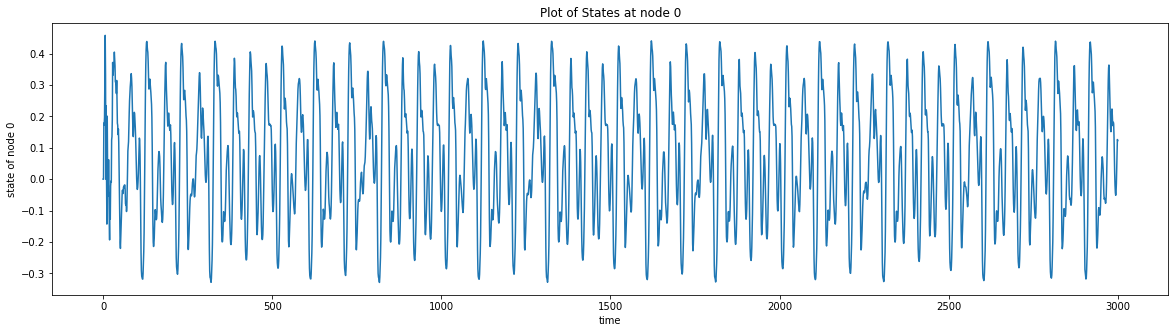

In [5]:
x_0 = np.zeros(shape=(N,1), dtype=float)

T = len(training_data)
T_bar = len(testing_data)

result = regression_sol(ld, remove_init=True)
print("States range from: {}".format(state_plot(result, True)))

z_predictions = []
z_actuals = []
trained_error = training_error(result)
print(trained_error)

0.029235214551083164


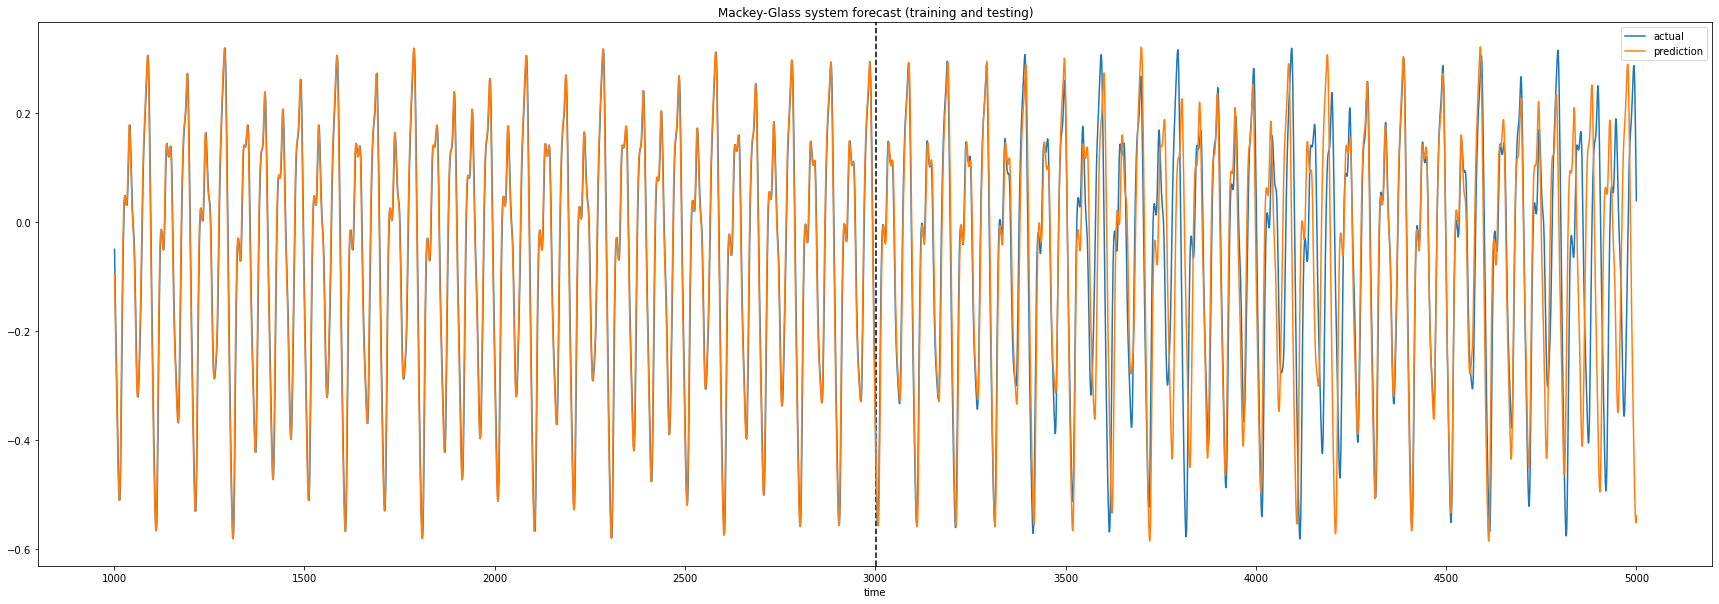

In [6]:
T = len(training_data)
T_bar = len(testing_data)

print(prediction(result))

forecast_plot, forecast_ax = plt.subplots(figsize=(30, 10))
forecast_ax.axvline(T, color='black', linestyle="--")
forecast_ax.plot(range(1001, T+T_bar), z_actuals, label='actual')
forecast_ax.plot(range(1001, T+T_bar), z_predictions, label='prediction')
forecast_ax.set_title('Mackey-Glass system forecast (training and testing)')
forecast_ax.set_xlabel('time')
forecast_ax.legend()

***

In [7]:
N = 1000
ld = 10**(-14)

In [8]:
C = gen_matrix(shape=(N,1), sparsity=0.6, sd=4, mean=-2, pdf="uniform", seeded=False)
gamma = 0.8

A = gen_matrix(shape=(N,N), sparsity=0.01, sd=2, mean=-1, pdf="uniform", seeded=False)
spec_rad = 1.2
A = spectral_radius_matrix(A, spec_rad)
        
s = 0.2
zeta = gen_matrix(shape=(N,1), sparsity=0.6, pdf="ones", seeded=False)

States range from: (-0.6882641011993675, 0.6892361903452056)
0.0010899578302383368


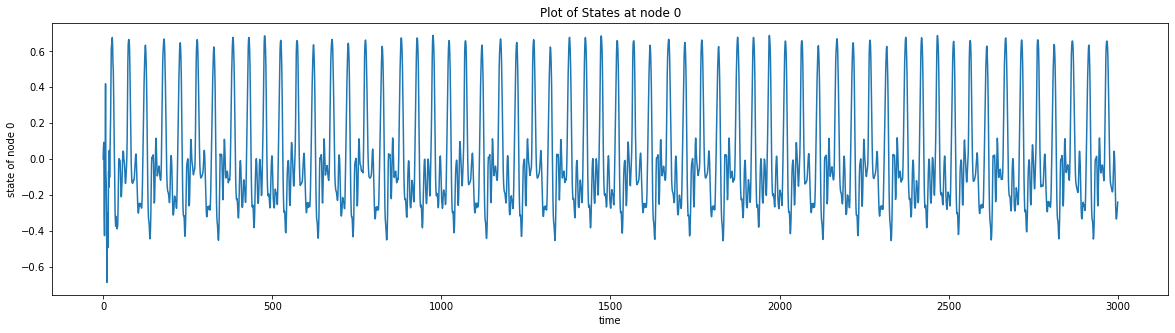

In [9]:
x_0 = np.zeros(shape=(N,1), dtype=float)

T = len(training_data)
T_bar = len(testing_data)

result = regression_sol(ld, remove_init=True)
print("States range from: {}".format(state_plot(result, True)))

z_predictions = []
z_actuals = []
trained_error = training_error(result)
print(trained_error)

0.013072278318494383


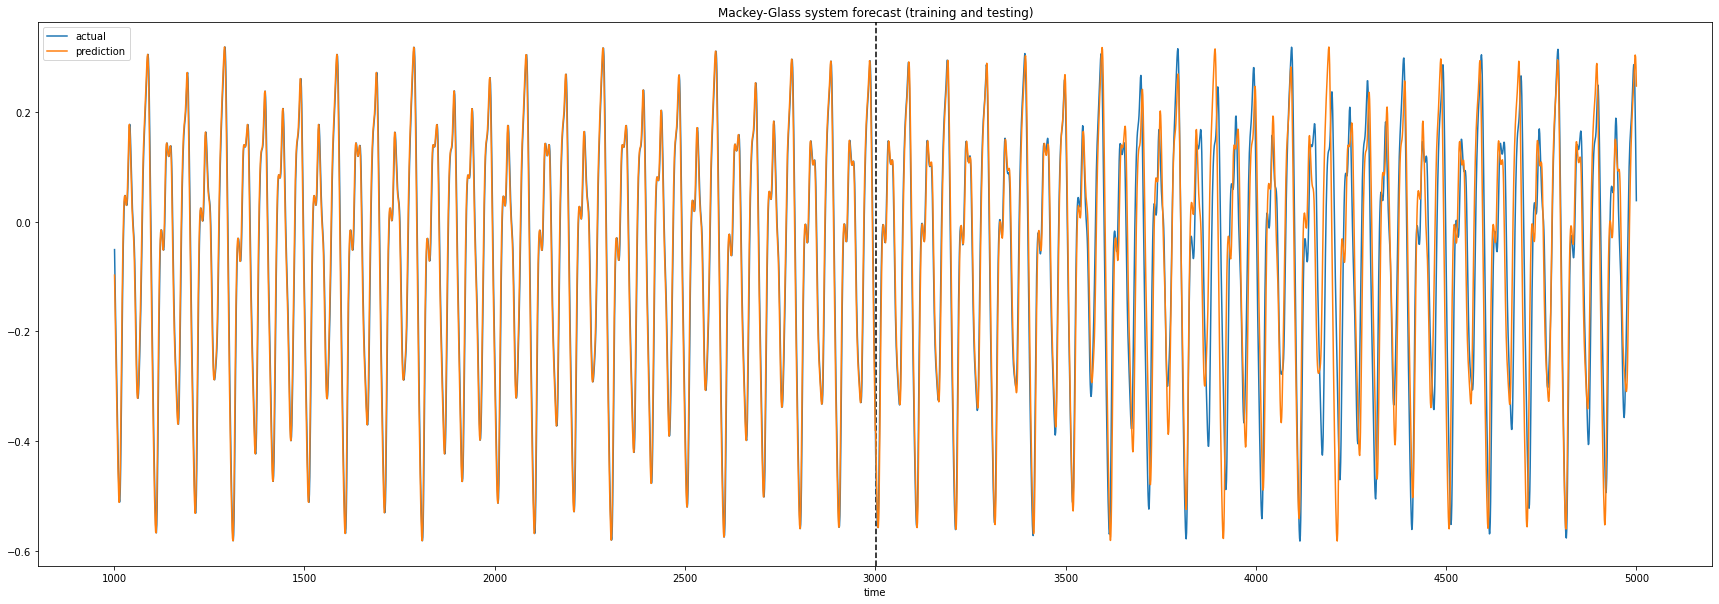

In [10]:
testing_data = data.loc[3002:]
#testing_data = testing_data.loc[3002:3086]
T = len(training_data)
T_bar = len(testing_data)

print(prediction(result))

forecast_plot, forecast_ax = plt.subplots(figsize=(30, 10))
forecast_ax.axvline(T, color='black', linestyle="--")
forecast_ax.plot(range(1001, T+T_bar), z_actuals, label='actual')
forecast_ax.plot(range(1001, T+T_bar), z_predictions, label='prediction')
forecast_ax.set_title('Mackey-Glass system forecast (training and testing)')
forecast_ax.set_xlabel('time')
forecast_ax.legend()

***

In [11]:
N = 1000
ld = 10**(-14)

In [12]:
C = gen_matrix(shape=(N,1), sparsity=0.6, sd=4, mean=-2, loc_seed=400, val_seed=450, pdf="uniform", seeded=True)
gamma = 0.8

A = gen_matrix(shape=(N,N), sparsity=0.01, sd=2, mean=-1, loc_seed=500, val_seed=490, pdf="uniform", seeded=True)
spec_rad = 1.2
A = spectral_radius_matrix(A, spec_rad)
        
s = 0.2
zeta = gen_matrix(shape=(N,1), sparsity=0.6, pdf="ones", loc_seed=400, seeded=True)

States range from: (-0.6734860354998136, 0.8600869898688647)
0.0010920626348223934


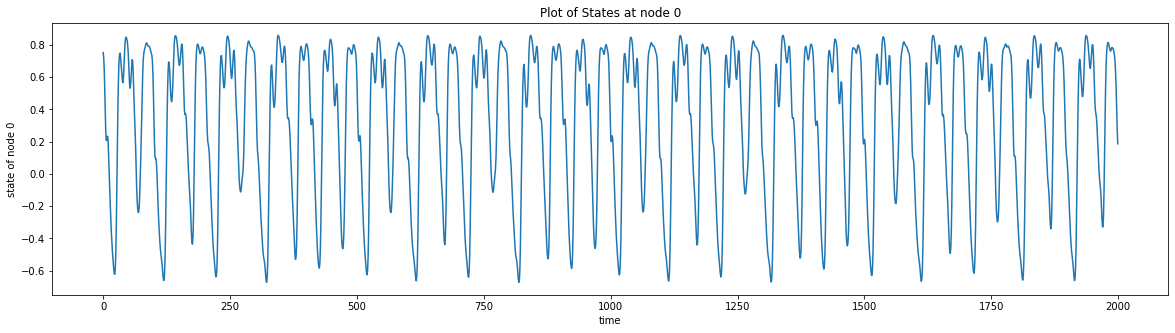

In [13]:
x_0 = np.zeros(shape=(N,1), dtype=float)

T = len(training_data)
T_bar = len(testing_data)

result = regression_sol(ld, remove_init=True) 
print("States range from: {}".format(state_plot(result, False, 0)))

z_predictions = []
z_actuals = []
trained_error = training_error(result)
print(trained_error)

0.008466731964825952


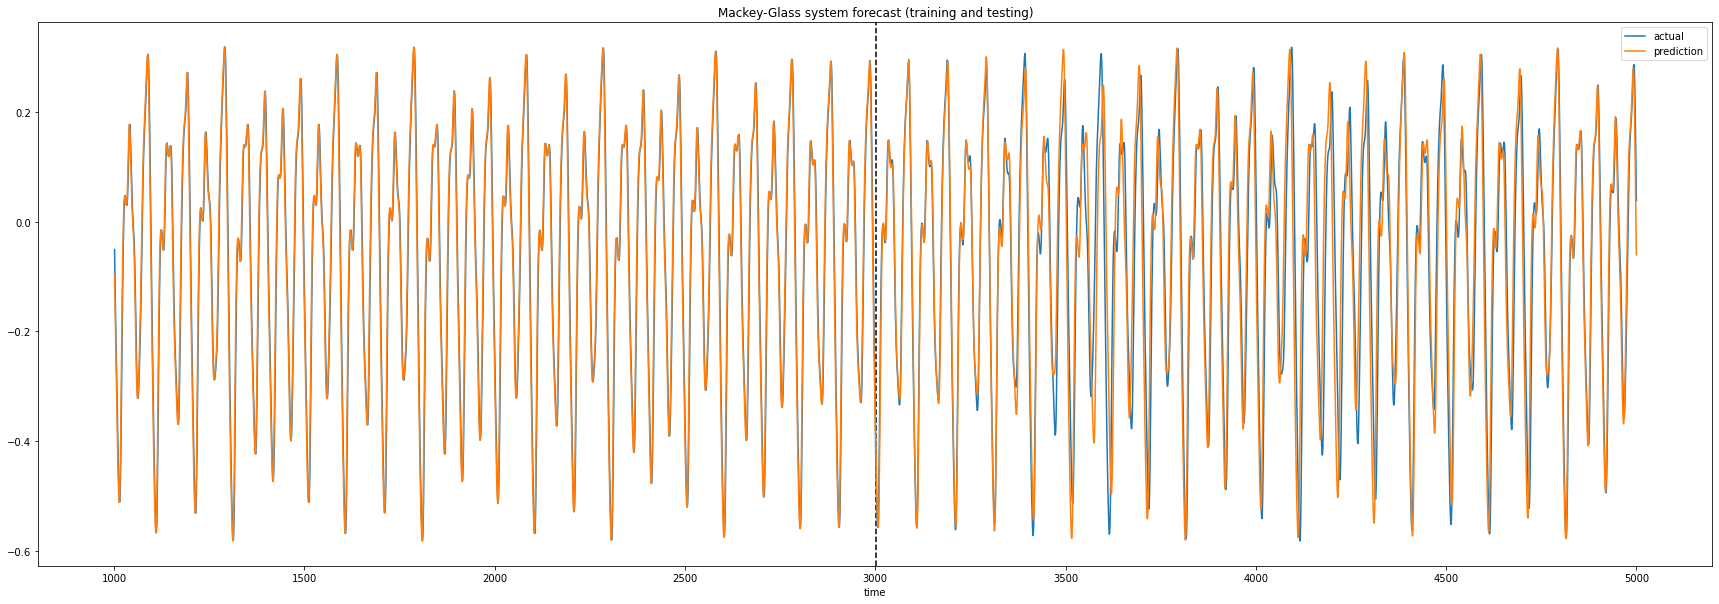

In [14]:
testing_data = data.loc[3002:]
#testing_data = testing_data.loc[3002:3086]
T = len(training_data)
T_bar = len(testing_data)

print(prediction(result))

forecast_plot, forecast_ax = plt.subplots(figsize=(30, 10))
forecast_ax.axvline(T, color='black', linestyle="--")
forecast_ax.plot(range(1001, T+T_bar), z_actuals, label='actual')
forecast_ax.plot(range(1001, T+T_bar), z_predictions, label='prediction')
forecast_ax.set_title('Mackey-Glass system forecast (training and testing)')
forecast_ax.set_xlabel('time')
forecast_ax.legend()

***

In [15]:
N = 1000
ld = 10**(-14)

In [16]:
C = gen_matrix(shape=(N,1), sparsity=0.6, sd=4, mean=-2, loc_seed=400, val_seed=403, pdf="uniform", seeded=True)
gamma = 0.8

A = gen_matrix(shape=(N,N), sparsity=0.01, sd=2, mean=-1, loc_seed=500, val_seed=508, pdf="uniform", seeded=True)
spec_rad = 1.2
A = spectral_radius_matrix(A, spec_rad)
        
s = 0.2
zeta = gen_matrix(shape=(N,1), sparsity=0.6, pdf="ones", loc_seed=400, seeded=True)

States range from: (-0.4821812738308315, 0.3788299531260302)
0.0010899503172427795


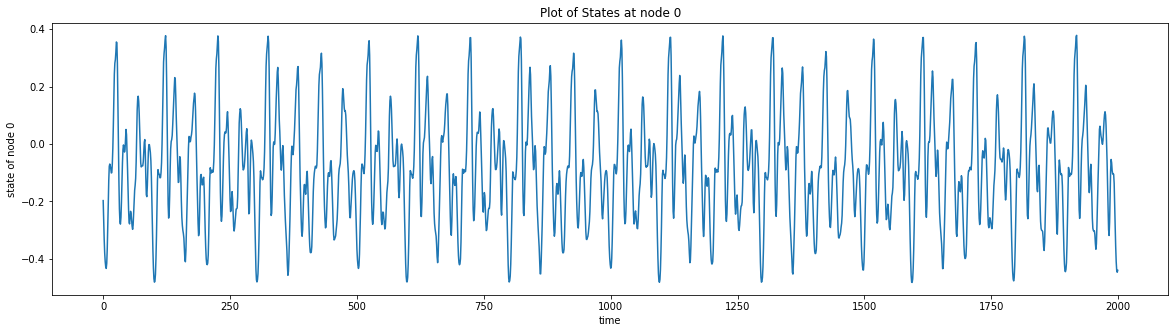

In [17]:
x_0 = np.zeros(shape=(N,1), dtype=float)

T = len(training_data)
T_bar = len(testing_data)

result = regression_sol(ld, remove_init=True) 
print("States range from: {}".format(state_plot(result, False, 0)))

z_predictions = []
z_actuals = []
trained_error = training_error(result)
print(trained_error)

0.0032316628362043754


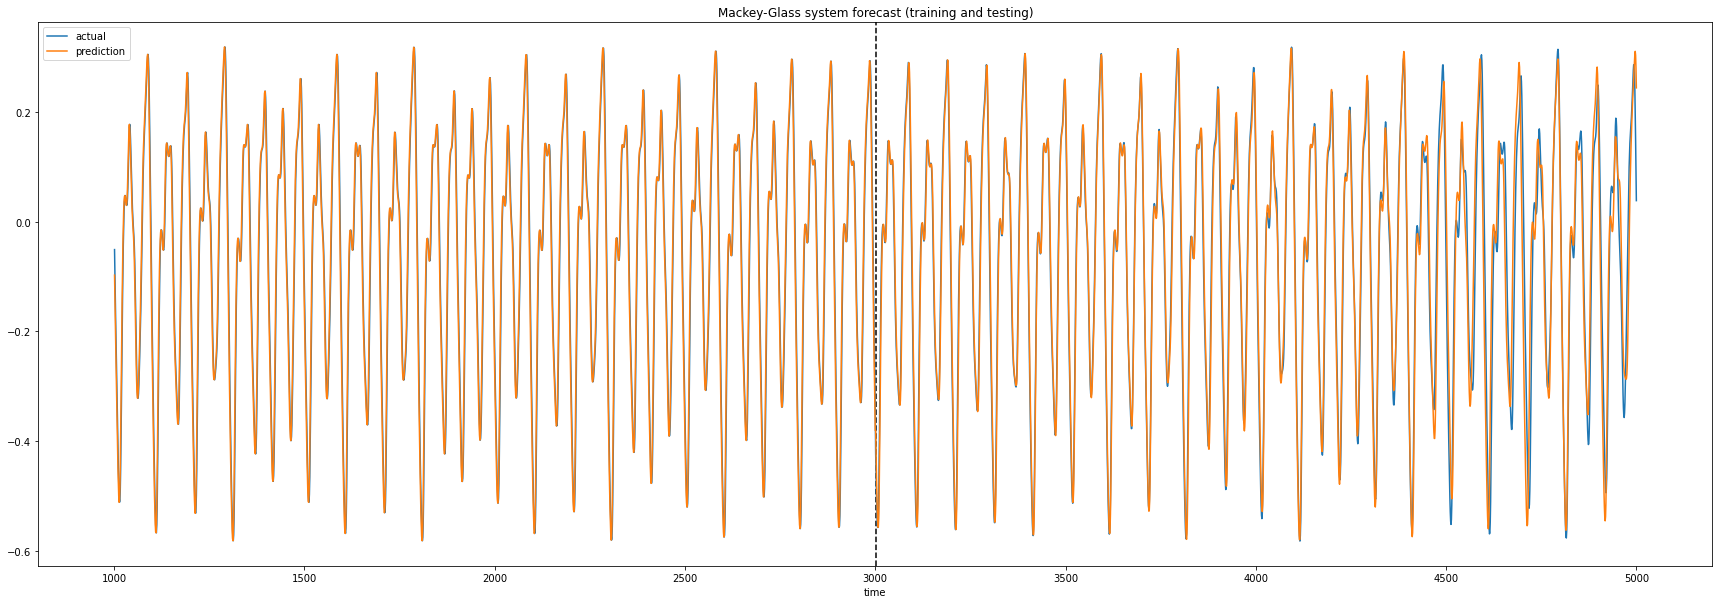

In [18]:
testing_data = data.loc[3002:]
#testing_data = testing_data.loc[3002:3086]
T = len(training_data)
T_bar = len(testing_data)

print(prediction(result))

forecast_plot, forecast_ax = plt.subplots(figsize=(30, 10))
forecast_ax.axvline(T, color='black', linestyle="--")
forecast_ax.plot(range(1001, T+T_bar), z_actuals, label='actual')
forecast_ax.plot(range(1001, T+T_bar), z_predictions, label='prediction')
forecast_ax.set_title('Mackey-Glass system forecast (training and testing)')
forecast_ax.set_xlabel('time')
forecast_ax.legend()

In [20]:
np.savetxt('best_weight.txt', result['best_weight'])

In [21]:
result['best_weight']

array([[-2.70605087e-04],
       [ 5.82861900e-03],
       [-8.78381729e-03],
       [ 1.33638382e-02],
       [-8.10384750e-04],
       [ 1.84137821e-02],
       [ 4.73469496e-03],
       [-4.98712063e-04],
       [-4.22647595e-03],
       [ 4.71082330e-03],
       [-9.98854637e-04],
       [-2.52615809e-02],
       [ 1.11420155e-02],
       [ 8.41426849e-03],
       [ 1.59945190e-02],
       [ 4.77898121e-03],
       [ 8.59633088e-03],
       [ 1.91327929e-03],
       [ 1.99859142e-02],
       [-2.45473385e-02],
       [-1.66139603e-02],
       [-2.68075466e-02],
       [ 1.91128254e-02],
       [ 1.17850304e-03],
       [ 5.09476662e-03],
       [ 5.48791885e-03],
       [-1.77187920e-02],
       [ 7.17794895e-03],
       [-1.00836754e-02],
       [-2.10462809e-02],
       [ 8.45456123e-03],
       [ 1.60686970e-02],
       [-1.15816593e-02],
       [-5.28097153e-03],
       [ 7.45081902e-03],
       [-4.43768501e-03],
       [-6.23703003e-04],
       [ 2.47637033e-02],
       [-1.5